<a href="https://colab.research.google.com/github/ahmedbellaaj10/GPGPU_TP/blob/main/Corr_Linear_classification_skeleton_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author : Désiré OUEDRAOGO

# Installation

In [ ]:
! git clone https://github.com/NVIDIA/cuda-samples.git

Cloning into 'cuda-samples'...
remote: Enumerating objects: 12395, done.
remote: Counting objects: 100% (12395/12395), done.
remote: Compressing objects: 100% (1894/1894), done.
remote: Total 12395 (delta 10520), reused 12332 (delta 10475), pack-reused 0
Receiving objects: 100% (12395/12395), 130.30 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (10520/10520), done.
Updating files: 100% (3673/3673), done.


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307

# Provided Code

## CUDA Utilities

In [ ]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major,
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))

//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Writing cuda_stuff.cuh


In [ ]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Writing cuda_stuff.cu


## fmatrix Matrix Tools

In [ ]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/* Access element (i,j) of matrix mat */
#define getfm(mat,i,j) (mat.data[IDX2C(i,j,mat.rows)])


int fmatrix_elements(fmatrix mat);
int fmatrix_size(fmatrix mat);
/** Assert that the matrix is coherent: all fields nonzero. */
void fmatrix_assert(fmatrix mat);

fmatrix fmatrix_create_on_host(int rows, int cols);
fmatrix fmatrix_create_on_device(int rows, int cols);
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);
fmatrix fmatrix_copy_to_host(fmatrix mat_host);
fmatrix fmatrix_copy_to_device(fmatrix mat_host);
void fmatrix_free_on_host(fmatrix* mat);
void fmatrix_free_on_device(fmatrix* mat);

/** Create a matrix representing columns [a,b) of M.
 *  Note that the new matrix points into the
 *  data of M. The data is not copied to a new location.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Print the first nb rows of the matrix mat
 *  on the host.
 *  If nb<0, print all rows.
 *
 * @attention: Works in device code if mat is on the device
 * and works in host code if mat is on the host.
 * All other cases require transferring the data first.
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device.
 *  If nb<0, print all rows.
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

#endif


Writing fmatrix.cuh


In [ ]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
    // the following is only valid if matrix data already allocated,
    // so it can't be used in create_on_... functions
    // return fmatrix_elements(mat) * sizeof(mat.data[0]);
    return fmatrix_elements(mat) * sizeof(float);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat));
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk(
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat))
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_device.data, mat_host.data,
                   fmatrix_size(mat_host),
                   cudaMemcpyHostToDevice
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,
                   fmatrix_size(mat_device),
                   cudaMemcpyDeviceToHost
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);
    fmatrix A = {
        .data = &getfm(M,0,a),
        .cols = b-a,
        .rows = M.rows
    };
    fmatrix_assert(A);
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}



Writing fmatrix.cu


## Data I/O

In [ ]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Writing read_csv.cuh


In [ ]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL);
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Writing read_csv.cu


In [ ]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Writing preprocess_data.cuh


In [ ]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major,
   ld = number of rows
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;
      }
		}

    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Writing preprocess_data.cu


# Code That You Write

## Classifier Math

In [ ]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P,fmatrix Z);

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////

void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C);

void fmatrix_transpose(fmatrix Z, fmatrix Z_T);

void fmatrix_add(fmatrix P,float a,fmatrix Y);

void sigma_mu(fmatrix A, fmatrix mu, fmatrix sigma);

void normalization(fmatrix A, fmatrix mu, fmatrix sigma);

#endif

Writing classifier_math.cuh


In [ ]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#define THREADS_PER_BLOCK 1024

/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}

__global__
void stable_softmax_kernel(fmatrix P, fmatrix Z) {

    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / Z.rows;
    int i = idx % Z.rows;
    if (i < Z.rows && j < Z.cols ){
      //getfm(P,i,j) = getfm(Z,i,j);
      float sum = 0;
      float max = getfm(Z,0,j);
      for (int k=0; k<Z.rows; k++){
          if(getfm(Z,k,j) > max){
            max = getfm(Z,k,j);
            }
      }
        for (int k=0; k<Z.rows; k++){
          sum += expf(getfm(Z,k,j) - max);
      }
      getfm(P,i,j) = expf(getfm(Z,i,j) - max) / sum;
    }
}

__global__
void fmatrix_transpose_kernel(fmatrix Z, fmatrix Z_T) {

    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / Z.rows;
    int i = idx % Z.rows;

    getfm(Z_T,j,i) = getfm(Z,i,j);

    //int j = blockIdx.x*blockDim.x+threadIdx.x;
    //int i = blockIdx.y*blockDim.y+threadIdx.y;
    //if (j < Z.rows && i < Z.cols )
    /*for(int i=0; i<Z.cols; i++){
      for(int j=0; j<Z.rows; j++){
          getfm(Z_T,j,i) = getfm(Z,i,j);
      }
    }*/
}

__global__
void fmatrix_add_kernel(fmatrix P,float a,fmatrix Y) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / P.rows;
    int i = idx % P.rows;
    if (i < P.rows && j < P.cols ){
        getfm(P,i,j) += a*getfm(Y,i,j);
    }
}

__global__
void fmatrix_multiplication_kernel(fmatrix A, float f, fmatrix B, fmatrix C) {
    // Each thread multiplies one row of B with one column of C
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / A.rows;
    int i = idx % A.rows;
    if (i < A.rows && j < A.cols ){
        getfm(A,i,j) = 0.0;
        for (int k = 0; k < B.cols; ++k) {
          getfm(A,i,j) += f*getfm(B,i,k)*getfm(C,k,j);
        }
    }
}

void fmatrix_transpose(fmatrix Z, fmatrix Z_T) {

    assert(Z.rows == Z_T.cols);
    assert(Z.cols == Z_T.rows);


    int threadsPerBlock = fmatrix_elements(Z);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }

    fmatrix_transpose_kernel<<< blocksPerGrid, threadsPerBlock >>>(Z, Z_T); // 1 thread pour la transposition

    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

  }


void softmax_col(fmatrix P,fmatrix Z) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);

    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the softmax here ...
    ///////////////////////////////////


    int threadsPerBlock = fmatrix_elements(Z);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    stable_softmax_kernel<<< blocksPerGrid, threadsPerBlock >>>(P,Z);

    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}



/* Compute A = f*B^T*C */
void fmatrix_mult(fmatrix A, float f, fmatrix B, fmatrix C) {
    // First let's check for errors in the argument M.
    // This can help a LOT when debugging.
    // A,B,C need to have nonzero pointers etc.
    fmatrix_assert(A);
    fmatrix_assert(B);
    fmatrix_assert(C);
    assert(A.rows == B.rows);
    assert(A.cols == C.cols);
    assert(B.cols == C.rows);

    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_multiplication_kernel<<< blocksPerGrid, threadsPerBlock >>>(A,f,B,C);

    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

  }

/** Compute P = P + a*Y */
void fmatrix_add(fmatrix P,float a,fmatrix Y) {
    fmatrix_assert(P);
    fmatrix_assert(Y);
    assert(P.rows == Y.rows);
    assert(P.cols == Y.cols);
    int threadsPerBlock = fmatrix_elements(P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_add_kernel<<< blocksPerGrid, threadsPerBlock >>>(P,a,Y);
    gpuErrchk( cudaPeekAtLastError() );
}



__global__
void sigma_mu_kernel(fmatrix X, fmatrix mu, fmatrix sigma ) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / X.rows;
    int i = idx % X.rows;
    if (i < X.rows && j < X.cols ){
      getfm(mu,i,0) = 0;
      for (int k=0; k<X.cols; k++){
          getfm(mu,i,0) += getfm(X,i,k);
      }
      getfm(mu,i,0) = getfm(mu,i,0) / (float) X.cols;

      getfm(sigma,i,0) = 0;
      for (int k=0; k<X.cols; k++){
          getfm(sigma,i,0) += powf((getfm(X,i,k) - getfm(mu,i,0)), 2.0);
      }
      getfm(sigma,i,0) =  sqrtf(getfm(sigma,i,0) / (float) X.cols);
    }
}

__global__
void normalization_kernel(fmatrix X, fmatrix mu, fmatrix sigma) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / X.rows;
    int i = idx % X.rows;

    if (i < X.rows && j < X.cols ){
      if (getfm(sigma,i,0) != 0){
      getfm(X,i,j) = (getfm(X,i,j) - getfm(mu,i,0))/getfm(sigma,i,0) ;
      }
    }
}

/* Compute sigma mu (A) */
void sigma_mu(fmatrix A, fmatrix mu, fmatrix sigma) {

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block

    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    sigma_mu_kernel<<< blocksPerGrid, threadsPerBlock >>>(A, mu, sigma);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}

/* Compute normalization(A) */
void normalization(fmatrix A, fmatrix mu, fmatrix sigma) {

    // take one thread per element, and distribute
    // over as many blocks as necessary given
    // the hardware limit on the number of threads per block

    int threadsPerBlock = fmatrix_elements(A);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    normalization_kernel<<< blocksPerGrid, threadsPerBlock >>>(A, mu, sigma);
    // check for errors
    gpuErrchk( cudaPeekAtLastError() );
    // wait for the kernel to finish
    device_synchronize();
}


Writing classifier_math.cu


## Evaluating Accuracy


In [ ]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(j,k)*log(P(j,k))
 */
void evaluate_logloss(fmatrix d_P,fmatrix d_Y,fmatrix d_J);

Writing evaluate_accuracy.cuh


In [ ]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>

#define THREADS_PER_BLOCK 1024

__global__
void evaluate_accuracy_kernel(fmatrix d_Y,fmatrix d_Z,int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }
}

float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);

  //////////////////////////////////////////
  // 1. compute Z = W^T X
  // --> each column of Z corresponds to one input
  //////////////////////////////////////////
  /*********************************
  / TO BE COMPLETED
  / ... compute Z = W^T X here ...
  **********************************/
  /* Compute d_Z = f*d_W^T*d_X */

  fmatrix d_W_T = fmatrix_create_on_device(d_W.cols,d_W.rows);
  fmatrix_transpose(d_W, d_W_T);
  fmatrix_mult(d_Z, 1.0, d_W_T, d_X);
  fmatrix_free_on_device(&d_W_T);


  //////////////////////////////////////////
  // 2. For each column z of Z,
  // find argmax_k z_k
  //////////////////////////////////////////


  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk(
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y,d_Z,d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}

__global__
void evaluate_logloss_kernel(fmatrix d_P,fmatrix d_Y, fmatrix d_J) {

    getfm(d_J,0,0) = 0.0;
    float temp = 0.0;
    for(int k=0; k<d_Y.cols ; k++)
      {
        for(int j=0; j<d_Y.rows; j++){
          if(getfm(d_Y,j,k) > 0.0 && getfm(d_P,j,k) > 0.0){
            temp = -getfm(d_Y,j,k)*logf(getfm(d_P,j,k));
            getfm(d_J,0,0) += temp;
          }


      }
    }

    getfm(d_J,0,0) *= 1.0 / d_Y.cols;
}



void evaluate_logloss(fmatrix d_P,fmatrix d_Y,fmatrix d_J) {
    assert(d_Y.cols == d_P.cols);
    assert(d_Y.rows == d_P.rows);
    fmatrix_assert(d_Y);
    fmatrix_assert(d_P);


    //float J = 0.0;

    ///////////////////////////////////
    // TO BE COMPLETED
    // ... compute the logloss here ...
    ///////////////////////////////////

    evaluate_logloss_kernel<<< 1, 1 >>>(d_P, d_Y, d_J);

    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

    //return J;
}


Overwriting evaluate_accuracy.cu


## Linear Classifier

In [ ]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{

    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; //12000; // points for training (Google: 12000)
    size_t N_test = 5000; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////

    // Logfile
    FILE* fp = fopen("log.txt", "w");

    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 40;           // defeault: 10;
    int periods = nb_iter;      // reporting period
    int batch_size = N;         // defeault: N;
    float learning_rate = 0.0001; // default: 1e-7

    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);

    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);

    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);

    fmatrix mu = fmatrix_create_on_device(d_X.rows,1);
    fmatrix sigma = fmatrix_create_on_device(d_X.rows,1);
    sigma_mu(d_X, mu, sigma);
    normalization(d_X, mu, sigma);

    fmatrix mu_test = fmatrix_create_on_device(d_X.rows,1);
    fmatrix sigma_test = fmatrix_create_on_device(d_X.rows,1);
    sigma_mu(d_Xtest, mu_test, sigma_test);
    normalization(d_Xtest, mu_test, sigma_test);

     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;

    clock_t tstart_total, tend;
    tstart_total = clock();

    //int batch_pointer = 0;

    for (int i=0; i<nb_iter; ++i){
                ////////////////////////////////
                // compute Z = W^T X
                // --> each column z of Z corresponds to one column x of X
                ////////////////////////////////

                ///////////////////////////////////
                // TO BE COMPLETED
                ///////////////////////////////////





                fmatrix d_W_T = fmatrix_create_on_device(d_W.cols,d_W.rows);
                fmatrix_transpose(d_W, d_W_T);

                fmatrix_mult(d_Z, 1.0, d_W_T, d_X);
                fmatrix_free_on_device(&d_W_T);

                ////////////////////////////////
                // For each column z of Z, compute activation p(z);
                // then update W
                ////////////////////////////////

                // compute softmax per column of Z and store in Z
                //fmatrix_device_print(d_Z);
                softmax_col(d_P,d_Z);
                //fmatrix_device_print(d_P);

                ///////////////////////////////////
                // TO BE COMPLETED
                ///////////////////////////////////

                // evaluate logloss (for reporting only)

                evaluate_logloss(d_P, d_Y, d_J);
                fmatrix_data_to_host(h_J,d_J);
                J = getfm(h_J,0,0);


                ///////////////////////////////////
                // TO BE COMPLETED
                ///////////////////////////////////

                // Q:=P-Y
                // compute gradient G = XQ^T
                // ... possibly work with G here ...
                // update weights W = W - learning_rate*G

                ///////////////////////////////////
                // TO BE COMPLETED
                ///////////////////////////////////

                fmatrix h_Q = fmatrix_create_on_host(M,batch_size);
                fmatrix d_Q = fmatrix_create_on_device(M,batch_size);
                fmatrix d_Q_T = fmatrix_create_on_device(batch_size,M);

                for(int l=0; l<M; l++){
                  for(int j=0; j<batch_size; j++){
                    getfm(h_Q,l,j) = 0.0;
                  }
                }

                fmatrix_data_to_device(h_Q, d_Q);

                fmatrix_add(d_Q, 1.0, d_P);
                fmatrix_add(d_Q, -1.0, d_Y);

                fmatrix_transpose(d_Q, d_Q_T);
                fmatrix_mult(d_G, 1.0, d_X, d_Q_T);

                //fmatrix_device_print(d_G);

                fmatrix_add(d_W, -learning_rate, d_G);

                //printf("W:\n");fmatrix_device_print(d_W);

                ////////////////////////////////
                // For reporting, compute logloss and accuracy
                ////////////////////////////////
                if (i%(nb_iter/periods)==0) {
                  float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
                  printf("iter: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
                  fprintf(fp, "%f,%f\n", J, accuracy);
                }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since
     *  they all point to Xall
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);

    // Close log file
    fclose(fp);
}

Overwriting linear_classification.cu


# Compiling

In [ ]:
!nvcc -arch=sm_35 -Wno-deprecated-gpu-targets -I /content/cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

# Experiments

In [ ]:
%%time
!./a.out

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.297000
iter: 0, logloss: 0.880316, accuracy: 0.720400
iter: 1, logloss: 0.504255, accuracy: 0.751000
iter: 2, logloss: 0.422960, accuracy: 0.761200
iter: 3, logloss: 0.386904, accuracy: 0.757

Let's plot the logloss and accuracy.

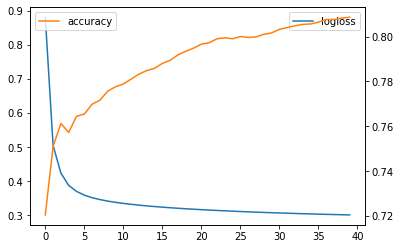

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
plt.legend()
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.legend()
plt.show()

loss = 0.300344 \
accuracy =  0.808200 \
hyperparameters : \
learning rate = 1e-4 \
nb_epochs = 40 \
batch_size = 12000

# Debugging
Compile with debugging info on the host (`-g`) and device (`-G`).


In [ ]:
!nvcc -g -G -I /content/cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

Run the debugger cuda-gdb, stopping at the first error that is detected. Shows first the call stack on the GPU, the values of local variables, then the call stack on the host (thread 1).

In [ ]:
! printf "set cuda memcheck on\nset cuda api_failures stop\ncatch throw\nr\nbt\ninfo locals\nthread 1\nbt\n" > tmp.txt
! cat tmp.txt
! cuda-gdb -batch -x tmp.txt ./a.out

set cuda memcheck on
set cuda api_failures stop
catch throw
r
bt
info locals
thread 1
bt
Catchpoint 1 (throw)
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 6 rows.
Allocated memory for inputs: 6 rows, 9 columns.
Allocated memory for labels: 6 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	
34.19	34.4	33.69	33.64	33.57	33.63	
15	19	17	14	20	29	
5612	7650	720	1501	1454	1387	
1283	1901	174	337	326	236	
1015	1129	333	515	624	671	
472	463	117	226	262	239	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	
Labels (first 10):
0	0	0	0	0	0	
1	1	1	1	1	1	
[
0.205141,	-0.063689;
0.170715,	0.179966;
0.248233,	-0.182383;
-0.099364,	0.161749;
-0.134007,	0.032545;
-0.013630,	0.077712;
-0.081538,	0.008081;
0.272705,	0.250975;
0.081837,	0.13

In [ ]:
!cuda-memcheck ./a.out

========= CUDA-MEMCHECK
========= This tool is deprecated and will be removed in a future release of the CUDA toolkit
========= Please use the compute-sanitizer tool as a drop-in replacement
headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 6 rows.
Allocated memory for inputs: 6 rows, 9 columns.
Allocated memory for labels: 6 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	
34.19	34.4	33.69	33.64	33.57	33.63	
15	19	17	14	20	29	
5612	7650	720	1501	1454	1387	
1283	1901	174	337	326	236	
1015	1129	333	515	624	671	
472	463	117	226	262	239	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	
Labels (first 10):
0	0	0	0	0	0	
1	1	1	1	1	1	
[
0.205141,	-0.063689;
0.170715,	0.179966;
0.248233,	-0.182383;
-0.099364,	0.161749;
-0.134007,	0.032545;
-0.013630,	0.077712;
-0.081538,	0.008081;
0.272705,	0.250975;
0.081837,	0.131035
]
initial accuracy: 1.000000
[
1.00